# Introduction to
![](pytorch-logo-dark.svg)
## Thomas Viehmann, MathInf GmbH
## [LOD 2021 Tutorial](https://lod2021.icas.cc/)

In [1]:
import torch

These slides are (c) 2020 by MathInf GmbH except graphics with attribution (and the PyTorch logo above).

Please use what you learn but don't just take my slides without asking. Thank you!

Thanks to: Giuseppe Nicosia for the invitation and virtual hospitability. Piotr Bialecki for feedback on the draft of these slides and many interesting perspectives on PyTorch and teaching PyTorch. Luca Antiga made the autograd graphic for our book.

In [2]:
%matplotlib inline
from matplotlib import pyplot
import numpy

assert torch.cuda.is_available(), "Some examples need the GPU"
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3090'

# Hello

I'm Thomas Viehmann.

- In 2018 I founded MathInf GmbH, a boutique ML research and development consultancy & PyTorch training company
- With &gt;150 patches I am one of the most prolific independent contributors to PyTorch.
- With Eli Stevens and Luca Antiga, I wrote [Deep Learning with PyTorch](https://pytorch.org/deep-learning-with-pytorch).
- I do some online course (advertised on my blog [lernapparat.de](https://lernapparat.de/)),
- Background: PhD in pen and paper Mathematics, have been an Actuary & Consultant for 10 years, Debian Developer emeritus


<img src="deep-learning-thumbnail.png" width=200px style="width: 200px; float: right;" />


# Plan

A mix of basic and advanced... but always practical!

- Part I: What is PyTorch? - A guided quick tour
- Part II: How can we make programs in PyTorch fast? - Model Optimization
- Part III: After training our model, are we done? -
     Aspects of deployment and the model lifecycle

# Part I: What is PyTorch?
### A guided quick tour

  We take a tour of PyTorch, nominally from 0, but we put best practices and pitfalls into the spotlight.
  - Tensors
  - Functions
  - **Autograd**
  - Models
  - Optimizers / Data
  - Predefined models + Ecosystem
 
  

# Part II: How can we make programs in PyTorch fast?
### Model optimization
  - Efficient modelling
  - Slow things and fast things in GPU computing
  - Beyond the model
  - Measuring in PyTorch (Benchmarking)
  - Live speedup of a model
  - Hard optimization and the JIT

# Part III: After training our model, are we done?

### Aspects of deployment and the model lifecycle

  - The PyTorch JIT for export
  - Keeping an eye on your model: Drift detection
    - Why, what, how
    - Better drift detection


# PyTorch is ... Tensors

At the heart of PyTorch is the Tensor data type. It is a multidimensional array.

When we speak of the dimension of tensors, it is the number of axes (or, in PyTorch, dimensions) - so dimension is in the sense of arrays, not the mathematical one.

Tensors can be 0d (i.e. scalars - single numbers), 1d (vectors), 2d (matrices), 3d...

In [3]:
t = torch.tensor([[0.7071, 1.4142, 1.6180],
                  [0.8346, 2.7183, 3.1416]])
t

tensor([[0.7071, 1.4142, 1.6180],
        [0.8346, 2.7183, 3.1416]])

## Tensors are arrays
Tensors have a shape (the size of each dimension):


In [4]:
t.dim(), t.shape

(2, torch.Size([2, 3]))

Indexing - also with assignments - works as expected. Use .item() to get numbers from tensors.

In [5]:
t[1, 2]

tensor(3.1416)

In [6]:
t[1, 2] = 3.141592653589793
t, t[1, 2].item()

(tensor([[0.7071, 1.4142, 1.6180],
         [0.8346, 2.7183, 3.1416]]),
 3.1415927410125732)

"Advanced indexing" with masks also works

In [7]:
t[t < 1] = 0
t

tensor([[0.0000, 1.4142, 1.6180],
        [0.0000, 2.7183, 3.1416]])

so does slicing

In [8]:
t[:, 1:], t[:, ::2], t[1, 2, None]

(tensor([[1.4142, 1.6180],
         [2.7183, 3.1416]]),
 tensor([[0.0000, 1.6180],
         [0.0000, 3.1416]]),
 tensor([3.1416]))

Tensors always hold elements (numbers) of a given scalar type, the "data type" or dtype.
For PyTorch (with its GPU focus), `float32` is perhaps the most common dtype.
Apropos GPU, they do have a device.

In [9]:
t.dtype, t.device

(torch.float32, device(type='cpu'))

We can move between devices and convert between dtypes.

In [10]:
t.to(dtype=torch.float64, device="cuda")  # if we have a GPU

tensor([[0.0000, 1.4142, 1.6180],
        [0.0000, 2.7183, 3.1416]], device='cuda:0', dtype=torch.float64)

## Tensors - a scenic view of memory blobs

Internally, Tensors are stored as a blob of memory

In [11]:
t.storage()

 0.0
 1.414199948310852
 1.6180000305175781
 0.0
 2.7183001041412354
 3.1415927410125732
[torch.FloatStorage of size 6]

In [12]:
t.stride(), t.shape, t.storage_offset(), t.data_ptr()

((3, 1), torch.Size([2, 3]), 0, 99365120)

In [13]:
t

tensor([[0.0000, 1.4142, 1.6180],
        [0.0000, 2.7183, 3.1416]])

Indexing and Slicing (and taking Diagonals, too) do *not* copy, but create views:

In [14]:
v = t[:, 2:]

In [15]:
v.stride(), v.shape, v.storage_offset(), v.data_ptr(), v.storage().data_ptr() 

((3, 1), torch.Size([2, 1]), 2, 99365128, 99365120)

In [16]:
v, v.storage()

(tensor([[1.6180],
         [3.1416]]),
  0.0
  1.414199948310852
  1.6180000305175781
  0.0
  2.7183001041412354
  3.1415927410125732
 [torch.FloatStorage of size 6])

(`data_ptr` already subsumes the storage offset...)

## Generalized tensors are tensors, too.

- These were strided tensors
- There are other Tensor types: Sparse, on TPU,...
- Quantized is a bit special, but similar in spirit.

In [17]:
t.layout

torch.strided

In [18]:
s = torch.sparse_coo_tensor(torch.arange(10)[None], torch.randn(10))
s, s.layout

(tensor(indices=tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]),
        values=tensor([-0.5283,  0.4430,  0.5310, -1.0570,  0.2895, -1.0272,
                        1.1280,  0.6830, -0.0562,  0.8406]),
        size=(10,), nnz=10, layout=torch.sparse_coo),
 torch.sparse_coo)

## Where to get Tensors?

PyTorch has ~90 factory functions:

- torch.tensor, torch.sparse_coo_tensor

- torch.zeros, ones, randn, ...

- torch.zeros_like, ones_like, randn_like, ...

Conversion to and from Numpy works without copying (there also is `torch.utils.dlpack` for a similar effect with GPU tensors)

In [19]:
a = t.numpy()
t2 = torch.from_numpy(a)
t2.data_ptr() == t.data_ptr()

True

Careful: Numpy uses a dtype of float64 by default, PyTorch float32 (as you typically want that for GPUs)

Sometimes you see FloatTensor, .data, ... in old code or copied from old code. Don't do that.

There also are `torch.utils.dlpack.to_dlpack` / `from_dlpack` for interchange with GPU tensors.

### Saving and loading tensors

Saving and loading tensors and dicts, lists of them (and other types) can be done though `torch.save` and `torch.load`. Optionally, you can specify where the tensors should be loaded to (the default is to put GPU tensors back on the GPU).

In [20]:
torch.save(t, 'my-tensor.pt')
torch.load('my-tensor.pt', map_location="cpu")

tensor([[0.0000, 1.4142, 1.6180],
        [0.0000, 2.7183, 3.1416]])

**Style advice**: Do use `.pt` as an extension, not `.pth` or anything else (`pth` collides with Python "path" files).

# PyTorch is ... operations on tensors

PyTorch mostly follows numpy in naming. Most things are available as methods (`t.tanh()`) and functions (`torch.tanh(t)`). More neural-network specific things are in `torch.nn.functional`.

I'm not going to list them, but generally we follow NumPy naming, the [documentation](https://pytorch.org/docs/) has all the details.

In [21]:
t.tanh(), torch.tanh(t)

(tensor([[0.0000, 0.8884, 0.9243],
         [0.0000, 0.9913, 0.9963]]),
 tensor([[0.0000, 0.8884, 0.9243],
         [0.0000, 0.9913, 0.9963]]))

Inplace operations are signaled by a trailing underscore `_`.

In [22]:
z = torch.randn(5, 5)
z.tanh_()
z


tensor([[-0.7156,  0.6660, -0.3969,  0.7263, -0.5892],
        [-0.1670,  0.8236,  0.0158, -0.4610,  0.6732],
        [ 0.8942, -0.0725, -0.3623,  0.9110, -0.8333],
        [-0.0252,  0.4489, -0.6231,  0.5585,  0.8250],
        [ 0.4238,  0.8421, -0.6662, -0.5534,  0.4282]])

The `torch.nn.functional` namespace (sometimes mapped to `F.`) contains functions that are more neural-network related.


In [23]:
w = torch.randn(10, 5)
i = torch.randn(2, 5)
torch.nn.functional.linear(i, w)

tensor([[-0.8668, -1.0281,  2.1666, -1.0091,  1.6341,  0.2331,  4.0137, -4.1339,
          0.8154, -0.2092],
        [-0.1300, -1.7957,  3.0111, -1.2490, -1.0192,  2.6302, -1.8312, -1.9049,
          0.3584, -1.0503]])

# PyTorch is ... autograd

PyTorch has a backpropagation-based autograd mechanism. It computes the gradient of *scalar* functions (and, by proxy of Jacobian-Vector products) at the point where is was evaluated. (Image from Deep Learning with PyTorch)

<img src='backprop.png' style='width: 100%' />

## Autograd in action

In [25]:
x = torch.linspace(-3, 3, 50, requires_grad=True)
y = torch.linspace(-3, 3, 50, requires_grad=True)

f = 10 * torch.sin(y)**2 + torch.tanh(x)
gr_x, gr_y = torch.autograd.grad(f.sum(), [x,y]) # gr always returns a list of gradients


NameError: name 'gr' is not defined

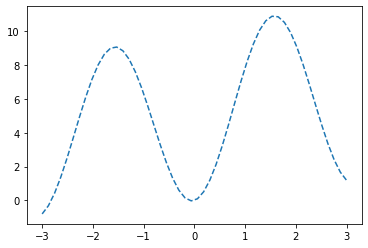

In [26]:
%matplotlib inline
from matplotlib import pyplot
pyplot.plot(x.detach().numpy(), f.detach().numpy(), '--')
delta = 0.2
for xi, fi, gi in zip(x[::10].tolist(), f[::10].tolist(), gr[::10].tolist()):
    pyplot.plot([xi-delta, xi+delta], [fi-delta*gi, fi+delta*gi]) # tangents at every 10th point

A mickey mouse example of optimizing a model (actually 100 times, starting from random initializations).

- We have 100 mini batches à 10 items.
- Each is, for a (normally) random $x$ the value $f(x) = \sin(2x)$.
- This we approximate by a 2-layer network with 10 hidden units. Our loss is the squared euclidean distance.
- By trying various starting values, we represent the uncertainty coming from the random initializaiton of the weights (of course, we would expect that to go away with more iterations).

In [27]:
final_preds = []
for no in range(100):   # 100 experiments
    w1 = torch.randn(1, 10, requires_grad=True)   # initialise random paramters
    b1 = torch.randn(10, requires_grad=True)
    w2 = torch.randn(10, 1, requires_grad=True)
    b2 = torch.randn(1, requires_grad=True)
    params = [w1, b1, w2, b2]

    for i in range(100):  # fitting 100 minibatches
        x = torch.randn(10, 1)   # input value
        target = torch.sin(2 * x)   # target value (usually from dataset)

        pred = torch.tanh(x @ w1 + b1) @ w2 + b2   # our model

        loss = ((pred - target) ** 2).sum()

        grads = torch.autograd.grad(loss, params)

        for p, g in zip(params, grads):
            with torch.no_grad():
                p -= 1e-2 * g

    with torch.no_grad(): # no gradients here...
        x0 = torch.linspace(-2, 2)
        final_preds.append(torch.tanh(x0[:, None] @ w1 + b1) @ w2 + b2)

final_preds = torch.cat(final_preds, dim=1)
final_preds.shape

<ipython-input-27-4c8c223fb653>:24: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /home/tv/pytorch/pytorch/aten/src/ATen/native/RangeFactories.cpp:20.)
  x0 = torch.linspace(-2, 2)


torch.Size([100, 100])

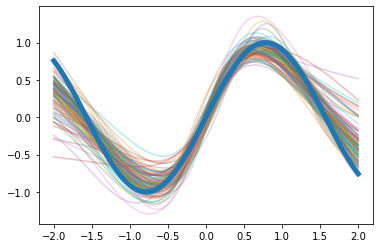

In [28]:
x0 = torch.linspace(-2, 2)
pyplot.plot(x0, final_preds, alpha=0.3)
pyplot.plot(x0, torch.sin(2 * x0), linewidth=5)

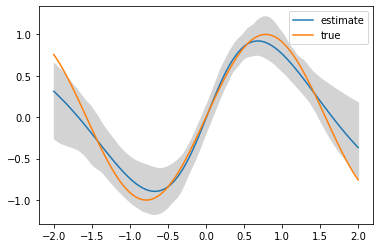

In [29]:
pyplot.plot(x0, final_preds.mean(1), label='estimate')
pyplot.plot(x0, torch.sin(2 * x0), label='true')
pyplot.fill_between(x0, numpy.percentile(final_preds, 2.5, axis=1), numpy.percentile(final_preds, 97.5, axis=1),
                   color='lightgray')
pyplot.legend()

## Leaves, intermediates, inplace and ...

There roughly are these types of tensors from an autograd perspective:

- "Plain" tensors, not requiring gradients (in particular all integral tensors).
- Leaves are the initial tensors requiring grad, from the factory functions or by taking a non-grad-requiring tensor and saying `t.requires_grad_()`.
- Computed tensors where an input requires gradients will, in general, require gradient.
- "views", tensors sharing memory, are special.

Let's look at this in some detail.

In [30]:
import graphviz
import warnings
def ptgraph(tensors=None):
    g = graphviz.Digraph()
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        names = {v:k for k,v in globals().items() if isinstance(v, torch.Tensor) and not k.startswith('_')}
        for n, m in globals().items():
            if isinstance(m, torch.nn.Module) and not n.startswith('_'):            
                names.update({p: n+':'+np for np, p in m.named_parameters()})
        new_names = names
        while new_names:
            new_names = {k.grad: v+'.grad' for k, v in new_names.items() if k.grad is not None}
            names.update(new_names)
        known_gradfns = {k.grad_fn: k for k,v in names.items() if k.grad_fn is not None}
    seen = set()
    def traverse_node(node):
        node = known_gradfns.get(node, node)
        node_id = str(hash(node))
        nodename = node.__class__.__name__
        if isinstance(node, torch.Tensor) and node in names:
            nodename = names[node]
            if node.grad_fn is None:
                g.node(node_id, nodename)
                return node_id
            node = node.grad_fn
            nodename = f'{nodename} ({node.__class__.__name__})'
        if hasattr(node, 'variable'):
            v = node.variable
            vn = names.get(v)
            node_id = str(hash(v))
            if vn is not None:
                nodename = f'{vn} ({nodename})'
        g.node(node_id, nodename)
        if node in seen:
            return node_id
        seen.add(node)
        for n ,p in node.next_functions:
            if n is not None:
                other_id = traverse_node(n)
                g.edge(other_id, node_id)
        return node_id
    if tensors is None:
        tensors = names.keys()
    elif not isinstance(tensors, (list, tuple)):
        tensors = [tensors]
    for t in tensors:
        other_id = traverse_node(t)
    return g

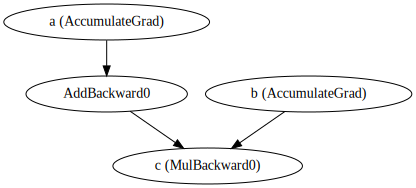

In [31]:
a = torch.randn(5, requires_grad=True)
b = torch.randn(5, requires_grad=True)
c = (a + 1) * b
ptgraph(c)


A common mistake is to accidentally throw away the true leaf. Note the difference between `a` and `b`.

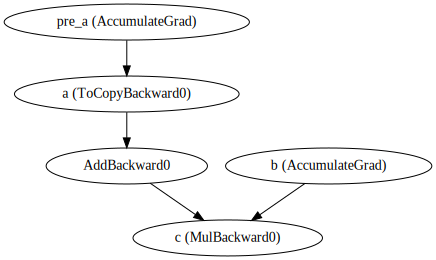

In [32]:
pre_a = torch.randn(5, requires_grad=True)
a =  pre_a.cuda()
b = torch.randn(5, requires_grad=True, device='cuda')
c = (a + 1) * b
ptgraph(c)

This would be a repaired version (but, if you can, working directly on the GPU is more efficient).

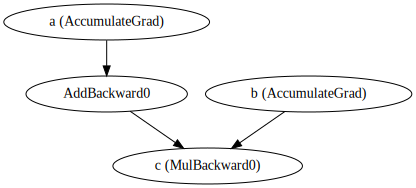

In [33]:
a = torch.randn(5).cuda().requires_grad_()
b = torch.randn(5, requires_grad=True, device='cuda')
c = (a + 1) * b
ptgraph(c)

You can cut things from autograd with `detach()` (and `detach_()`)

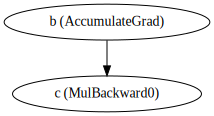

In [34]:
a = torch.randn(5, requires_grad=True).cuda()
b = torch.randn(5, requires_grad=True, device='cuda')
c = (a + 1).detach() * b
ptgraph(c)

Inplace with autograd can be tricky

In [35]:
a = torch.randn(5, requires_grad=True)
b1 = a + 1
b2 = b1 + 1

b1 += 1

torch.autograd.grad(b2.sum(), a) # works


(tensor([1., 1., 1., 1., 1.]),)

In [36]:
a = torch.randn(5, requires_grad=True)
b1 = a + 1
b2 = b1 ** 2
b1 += 1

torch.autograd.grad(b2.sum(), a) # this would need the original b1

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [5]], which is output 0 of AddBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

We did not get a TraceBack in Jupyter before PyTorch 1.7 (PR #41116), but now we get too much (the crucial `b2 = b1 ** 2` is there, but off-screen)...

In [37]:
with torch.autograd.detect_anomaly():
    a = torch.randn(5, requires_grad=True)
    b1 = a + 1
    b2 = b1 ** 2
    b1 += 1

    torch.autograd.grad(b2.sum(), a) # this would need the original b1

<ipython-input-37-fb1eaba42148>:1: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():
/usr/local/lib/python3.9/dist-packages/torch/autograd/__init__.py:234: UserWarning: Error detected in PowBackward0. Traceback of forward call that caused the error:
  File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/lib/python3/dist-packages/tornado/platform/asyncio.py", line 199, in start

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [5]], which is output 0 of AddBackward0, is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

There are some opportunities where inplace is actually very useful. One of my faviourite tricks is to copy things into a preallocated tensor.

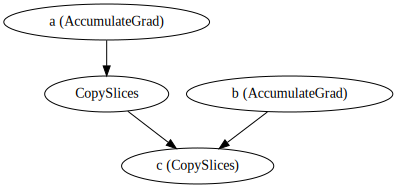

In [38]:
a = torch.randn(5, requires_grad=True)
b = torch.randn(5, requires_grad=True)
c = torch.zeros(4, 7)  # padded torch.stack([a,b])
c[1, 1:-1] = a
c[2, 1:-1] = b
c
ptgraph(c)

In [39]:
gr_a, gr_b = torch.autograd.grad(c.sum(), [a, b])
assert (gr_a -1).abs().max().item() < 1e-6 and (gr_b -1).abs().max().item() < 1e-6  # float and "==" don't mix well

## Inplace Summary


There are two main situations where inplace operations cannot be used:

- When operating on leaf tensors, the leaf tensor would be moved into the graph, which would be bad.
- When the operation before the inplace wants to have its result to compute the backward. Whether this is the case is not easy to tell from the outside, unfortunately.

As a corollary, you should avoid using inplace on the inputs of your re-usable module lest in the future use could be in one of the two situations.

Later: You might also be less eager to use inplace when planning to use the JIT, as it will fuse pointwise non-inplace operations like ReLU if there are several in a row.


For validation, inference or other things where the *end user* decides she does not want gradients, there is the `torch.no_grad` context manager.

We'll use it below to evaluate models after training.

- If you need to use `torch.no_grad()` somewhere where it isn’t because you’re evaluating something that’s written for training, you should ask yourself if you’re doing it wrong.

- Using item and detach for things to keep around longer than the next backward is generally a good idea (e.g. when you record loss history, statistics, …), but be careful to not ruin your graph. (Targeted detach is good in nn.Module subclass code, with torch.no_grad() should be needed very rarely.)

It is not true that tensors created in `torch.no_grad` never require grad (as often views are special):

In [40]:
a = torch.randn(5, 5, requires_grad=True)

with torch.no_grad():
    b = a * 2
    c = a[:2, :2]

b, c

#with torch.inference_mode(): won't track views

(tensor([[-1.7303,  2.7394,  2.2591, -0.4502, -2.2576],
         [-0.8640, -0.9364,  2.6627, -1.2754, -1.7908],
         [ 2.5884,  4.4431, -3.6362,  0.8776,  0.4456],
         [ 3.1636,  0.3777,  1.7199, -0.6238,  3.1114],
         [-1.8418, -3.2351,  0.7988,  1.0383,  0.6543]]),
 tensor([[-0.8651,  1.3697],
         [-0.4320, -0.4682]], requires_grad=True))

### Second derivatives

You cannot get Hessians, but you can get Hessian vector products or really derivatives of any scalar function of the gradient.

In [41]:
a = torch.arange(5., requires_grad=True)
b = a ** 4
gr, = torch.autograd.grad(b.sum(), [a], create_graph=True)
hvp, = torch.autograd.grad(gr.sum(), [a])  # what is the vector in HVP?
a, hvp # 4 * 3 * x

(tensor([0., 1., 2., 3., 4.], requires_grad=True),
 tensor([  0.,  12.,  48., 108., 192.]))



## `backward` as a convenience method

Above we used `torch.autograd.grad`. More commonly, you find `loss.backward()`. This is a convenience method for computing the gradient of all leaves `t` and storing the gradient in `t.grad`.
In particular, PyTorch's built-in optimizers use these.

You can ask for a gradient of an intermediate to be stored by `t.retain_grad()`.

My advice: Only use backward to get gradients to then use with the optimizer. Don't use backward with 
`create_graph`.

## A fun trick

Sometimes, we want the backward to not quite be like the forward. Round obviously has gradient 0, but wouldn't it be sometimes be convenient if...

In [42]:
a = torch.randn(5, requires_grad=True)
b = a.round()
gr, = torch.autograd.grad(b.sum(), [a])
gr

tensor([0., 0., 0., 0., 0.])

...we can actually do that (not this construction, but the same rounding trick is the gist of "quantization aware training", other things like "gumble softmax" also work like this):

In [43]:
def differentiable_round(a, ndigits=None):
    if ndigits is None:
        b = a.round()
    else:
        scale = 10 ** ndigits
        b = (a * scale).round() / scale
    return a + (b - a).detach()  # PyTorch's version of "cleverly add 0"
c = differentiable_round(a)
gr2, = torch.autograd.grad(c.sum(), [a])
(c == b).all().item(), gr2

(True, tensor([1., 1., 1., 1., 1.]))

Fake quantization training the hard way

In [44]:
w1 = torch.randn(1, 10, requires_grad=True)
b1 = torch.randn(10, requires_grad=True)
w2 = torch.randn(10, 1, requires_grad=True)
b2 = torch.randn(1, requires_grad=True)
params = [w1, b1, w2, b2]


for i in range(200):
    x = torch.randn(10, 1)
    target = torch.sin(2 * x)

    xr = differentiable_round(x)
    w1r = differentiable_round(w1, 1)
    b1r = differentiable_round(b1, 1)
    w2r = differentiable_round(w2, 1)
    b2r = differentiable_round(b2, 1)
    pred = torch.tanh(xr @ w1r + b1r) @ w2r + b2r

    loss = ((pred - target) ** 2).sum()

    grads = torch.autograd.grad(loss, params)

    for p, g in zip(params, grads):
        with torch.no_grad():
            p -= 1e-2 * g

Did it work?

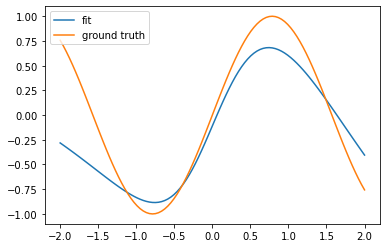

In [45]:
with torch.no_grad(): # no gradients here...
    w1r = differentiable_round(w1, 1)
    b1r = differentiable_round(b1, 1)
    w2r = differentiable_round(w2, 1)
    b2r = differentiable_round(b2, 1)
    x0 = torch.linspace(-2, 2)
    final_preds = torch.tanh(x0[:, None] @ w1r + b1r) @ w2r + b2r
    gt = torch.sin(2*x0)

pyplot.plot(x0, final_preds, label='fit')
pyplot.plot(x0, gt, label='ground truth')
pyplot.legend()

# PyTorch is ... a Neural Network (and general Modelling) Library

`torch.nn.Module` and subclasses play the central role as Neural Network building blocks.
Modules are for bundling neural network *state*, i.e. Parameters, other Buffers, Submodules, with the rules to compute outputs from inputs.
- Parameters: wrap in torch.nn.Parameter + assign
- Buffers (Tensors noch trained via SGD, e.g. statistics): register_buffer
- Submodules: assign

Here is the equivalent of our previous model:

In [48]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = torch.nn.Parameter(torch.randn(1, 10))
        self.b1 = torch.nn.Parameter(torch.randn(10))
        self.w2 = torch.nn.Parameter(torch.randn(10, 1))
        self.b2 = torch.nn.Parameter(torch.randn(1))
  
    def forward(self, x):
        return torch.tanh(x @ self.w1 + self.b1) @ self.w2 + self.b2

model = MyModel()
model.to(device="cuda")
model.w1

Parameter containing:
tensor([[-1.4614,  0.7908,  0.8986, -0.0263,  0.6208, -0.4654,  0.1735,  0.5412,
          1.4698,  0.5524]], device='cuda:0', requires_grad=True)

A rich library of pre-made modules under `torch.nn`.
- `torch.nn.Linear`, `Conv2d`, `MaxPool2D`, `Tanh`, ...
Also loss functions:
- `CrossEntropyLoss`, `MSELoss`, `CTCLoss`...

Careful: Naming `CrossEntropyLoss` vs. `NLLLoss` etc. is particular to PyTorch. Check the documentation for PyTorch's expectation of whether input have `softmax` / `log_softmax`  / something else applied.

We can make our model again with these:

In [49]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(1, 10)
        self.l2 = torch.nn.Linear(10, 1)
  
    def forward(self, x):
        x = torch.tanh(self.l1(x))
        return self.l2(x)

model = MyModel()
model

MyModel(
  (l1): Linear(in_features=1, out_features=10, bias=True)
  (l2): Linear(in_features=10, out_features=1, bias=True)
)

There also is a `Sequential` class for particularly simple "chains" of modules (with only one input/output).

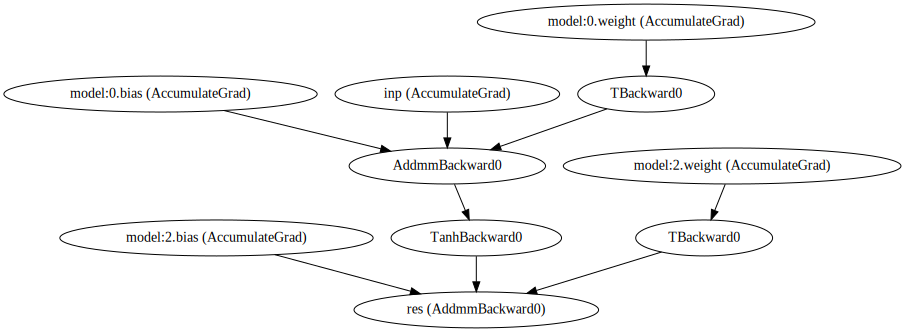

In [50]:
model = torch.nn.Sequential(
            torch.nn.Linear(1, 10),
            torch.nn.Tanh(),
            torch.nn.Linear(10, 1))

inp = torch.randn(5, 1, requires_grad=True)
res = model(inp)
ptgraph(res)

Task: Can you subclass sequential to get a model class?

### Loading and Saving models

While you can save and load models using `torch.save` and `torch.load`, it is generally not recommended.

Instead, save the state dict and upon loading instantiate the model and load the state dict. This is much better for forward compatibility.


In [51]:
torch.save(model.state_dict(), 'saved_model.pt')
sd = torch.load('saved_model.pt')
model.load_state_dict(sd)


<All keys matched successfully>

## Some thoughts on functional vs. Module

- If you write for re-use, the functional / Module split of PyTorch has turned out to be a good idea.

- Use functional for stuff without state (unless you have a quick and dirty Sequential).

- Never re-use modules (define one `torch.nn.ReLU` and use it 5 times). It's a trap!

  When doing analysis or quantization (when `ReLU` becomes stateful due to quantization params), this will break.


# PyTorch has ... optimizers

In `torch.optim`.

- Most common probably: `torch.optim.SGD`, `torch.optim.Adam`, but also `torch.optim.LBFGS` etc.
- Schedules for the learning are also available.

Pattern:
- `loss = ...`
- `opt.zero_grad()`
- `loss.backward()`
- `opt.step()`

Optimizers also have a `state_dict` for saving / restoring.

Let's see that in action with our toy model:

In [52]:
model = torch.nn.Sequential(
            torch.nn.Linear(1, 10),
            torch.nn.Tanh(),
            torch.nn.Linear(10, 1))

opt = torch.optim.SGD(model.parameters(), lr=1e-2)

for i in range(200):
    x = torch.randn(10, 1)    # input  from dataset
    target = torch.sin(2 * x) # target from dataset

    pred = model(x)
    loss = torch.nn.functional.mse_loss(pred, target, reduction='sum')
    
    opt.zero_grad()
    loss.backward()
    opt.step()

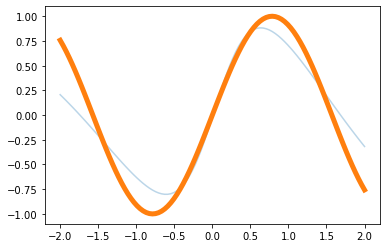

In [53]:
with torch.no_grad():
    x0 = torch.linspace(-2, 2)
    pyplot.plot(x0, model(x0[:, None]).detach(), alpha=0.3)
    pyplot.plot(x0, torch.sin(2 * x0), linewidth=5)

# PyTorch has ... utilities for data handling

PyTorch splits data handling in two parts:
- Problem specific (DataSet)
- Generic, e.g. Sampling, Batching (DataLoader)

User's responsibility: Define `torch.utils.data.DataSet` subclass with
- a `__len__` method (how many data points)
- a `__getitem__` method to get the `i`th element, returning tuples of numbers and tensors

`DataLoader` is more or less universal. In several parallel processes, get items from dataset and assemble
them into batches (for numbers, tensors, make tensors, for other things, lists).

Let's try that:

In [54]:
import torch.utils.data
class DS(torch.utils.data.Dataset):
    def __init__(self, shape):
        self.shape = shape
    def __len__(self):
        return 100
    def __getitem__(self, i):
        return (i % 10 + torch.randn(self.shape), i % 10) # observation and label
    
ds = DS((5,))
dl = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True)

for inp, label in dl:
    print(inp, label)
    break

tensor([[ 0.2976,  1.5696,  0.8601,  0.9776, -0.0787],
        [ 1.1655, -0.3452, -0.2399,  2.2645,  1.3088],
        [ 1.7672,  2.5784,  3.2223,  3.0295,  2.1929],
        [ 9.5243,  5.8201,  5.7739,  6.7126,  7.6045],
        [-0.7799, -0.0703,  0.5571,  0.4670, -0.7049],
        [ 5.1953,  5.5916,  3.6525,  6.3894,  4.5062],
        [ 3.4630,  6.6136,  6.8916,  5.1539,  5.8120],
        [ 6.5675,  7.2459,  6.8618,  5.1527,  7.5645]]) tensor([1, 1, 2, 7, 0, 5, 6, 7])


What happened here?

The DataLoader provides an iterator and for each iteration

- requested elements from the dataset,
- took the 1d `5`-tensors and `stack`ed them to a 2d `batchsize x 5` tensor,
- took the integers and put them into a 1d `batchsize` tensor.
- gives the tuple of input and label to the for loop.

**Good to know**: If `batchsize` does not divide `len(ds)`, the last batch will be shorter. This can be troublesome (e.g. batch norm running with a batch size of 1), so you have the `drop_last` optional command to just skip this minibatch.

## Practical data aquisition

Datasets, Dataloaders and utility functions:

TorchVision, TorchAudio, TorchIO (medical data)

HuggingFace's Transformers for text (at a high level), TorchText, TorchNLP

Pretrained models:
- Vision: TorchVision, PyTorch Imaging Models (TIMM)
- NLP: Transformers library

...and on individual projects.


# PyTorch is ... much more

We skipped `torch.distributions`, `distributed`, automatic mixed precision and more PyTorch has to offer. Check out the tutorials on PyTorch.org.

## Forums

Forums at [discuss.pytorch.org](https://discuss.pytorch.org/) probably are the best source of casual help, with a number of core developers also keeping an eye for the advanced questions. (I'm @tom there.)

## Wider Ecosystem

Libraries for many classes of models building on PyTorch (not complete)

- Immediate "Satellites" like TorchVision, TorchAudio, TorchText, TorchServing
- Extending capabilities: PyTorch Imaging Models (timm), Transformers, PyTorch-NLP, Graph NNs, Gaussian Processes, Pyro (Probabilistic)
- Training helpers

# Part II: How can we make programs in PyTorch fast?

### Model optimization

  - Efficient modelling
  - Slow things and fast things in GPU computing
  - Beyond the model
  - Measuring in PyTorch (Benchmarking)
  - Fusion and automatic optimization
  - Live speedup of a model
  

# Efficient modelling

remember that modelling does have a huge lever regarding efficiency<br/>
**if you care about efficiency make your model large but as small as possible**

<table>
    <tr>
        <td>
Millions of parameters vs. timeline for the popular transformer models
<img src="distilbert.png" width="80%" />
        </td>
        <td><img src="efficientnet_flops.png" width="80%" /></td>
    </tr>
    <tr><td>
Source: V. Sanh (Huggingface), DistilBERT
        </td><td>Source: M. Tan, Q. Le: EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks</td></tr>
</table>


### Slow things and fast things in GPU computing

The "what" typically should be the first optimization target,
in terms of overall modelling and also computational algorithms.

But when we fix the task ("what"), how can we optimize?

Conventional wisdom: **Python is slow**

- certainly, Python isn't fast (`for` loop vs C++ `for` loop)
- in practice, more often than not, Python isn't the bottleneck


### How PyTorch programs spend their time

At a very high level, you can divide time spent into these parts:
- Python program flow,
- Data "administrative overhead" (creating `Tensor` data structures, autograd `Node`s etc.),
- Data aquisition (I/O),
- Computation roughly as
  - fixed overhead (kernel launches etc.),
  - reading / writing memory,
  - "real computation",

**Thomas' rule of thumb**: As long as your operands are reasonably large (say 100s of elements, not single elements), Python and Data "administrative overhead" probably isn't your main problem.

### Data aquisition and I/O

Using `Dataset` / `DataLoader` is simple, but keep in mind that it can greatly impact performance.

How do you detect this? If, during training, your GPU is not constantly fully used (shown by `*smi` tools), you have a CPU bottleneck somewhere, and the data loading is one thing to check.

- If more cores help, there is the `num_workers` argument to the dataloader.
- Fast hardware helps: SSD vs. HDD.
- If you can do preprocessing beforehand (no augmentation), try that. (But careful, I/O is often more expensive than processing.)
- If you can do preprocessing on the GPU instead (augmentation in particular), do that.
- Sometimes it helps to put tensors into _GPU pinned memory_, with the `pin_memory` argument for the DataLoader.

### Computation

Computation with CPU and GPU includes synchronization
- GPU waits for the CPU (i.e. GPU sits idle when it should be used),
- CPU waits for the GPU (to get the results) aka synchronization points

  - GPU computation is and shold be ansynchronous, but
  - Synchronizations can happen because the program needs to know something (e.g. sizes of tensors depending on the input). Often, these are unavoidable.
  - Typical sources of spurious synchronizations are too frequent 
    `.to(device="cpu")`, `.item()`, `.to_list()`, `print`.
- in distributed settings synchronization between nodes.

Typical indication: GPU utilization is bad. While your program runs, check e.g. `nvidia-smi` (or `rocm-smi`).

## Your program is more than your model

Typical steps:

- Data loading / augmentation
- Running the models
- Processing intermediate results
- postprocessing, logging

As quite a lot of these do not involve the GPU (before optimization...), again check GPU utilization for first hints.

# Measurement and benchmarking

One of my informal mottos is _It's not optimization until you measure_. 

When you think about code being slow, it's important to figure out what is slow and why.
To my mind, a lot of measurement can be done with very basic tools, e.g. IPython's `%timeit` magic.

Important rules when timing:
- If we want to time GPU kernels from CPU, we want to be sure to synchronize before taking the start and end times.
- Typically, we also want to have some "warm-up", i.e. run the measured function
  for a few times before timing to avoid measuring one-off overheads.
- Always use a mononic clock (`time.perf_counter()` instead of ~~`time.time()`~~).
- Try to cover everything of interest (s.t. wall-clock-time ≈ total measured).
- Turn off powermanagement and make sure there is no thermal throtteling...


### First practical example from the wild

Here is how one might use `%timeit` for a "microbenchmark".
Here, we change the computation strategy for a given function.

Let's take the uniformity loss from [Wang and Isola: Understanding Contrastive Representation Learning through Alignment and Uniformity on the Hypersphere](https://arxiv.org/abs/2005.10242) (a great paper!).

The Uniformity loss is defined as a function of the pairwise distances over a largish set of vectors.


In [95]:
def lunif(x, t=2): # copied from the paper
    sq_pdist = torch.pdist(x, p=2).pow(2)
    return sq_pdist.mul(-t).exp().mean().log()

x = torch.randn(1024, 128, device="cuda")
x /= x.norm(p=2, dim=1, keepdim=True).requires_grad_()

lunif(x)

tensor(-3.9382, device='cuda:0', grad_fn=<LogBackward0>)

One would think that the specialised `pdist` function is the right tool for the job.
But is it? Let's time it.

In [97]:
def totime(fn):
    l = fn(x)
    g, = torch.autograd.grad(l, x)
    torch.cuda.synchronize()

totime(lunif) # warmup
%timeit totime(lunif)

8.99 ms ± 21 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Let's use $|x-y|^2 = |x|^2 + |y|^2 - 2 <x, y>$ and compare.

In [98]:
def lunif2(x, t=2):
    t=2
    xnorm = torch.norm(x, p=2, dim=1).pow(2)
    sq_pdist = xnorm[None] + xnorm[:, None] - 2 * torch.mm(x, x.t())
    exp = sq_pdist.mul(-t).exp().tril(diagonal=-1)
    N = x.size(0)
    res = exp.sum().mul(2/(N*N-N)).log()
    return res

print((lunif2(x.to(torch.double)) - lunif(x.to(torch.double))).item())

totime(lunif2)
%timeit totime(lunif2)

0.0
627 µs ± 5.08 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Even though we have stark inefficiencies (like taking tril and taking a copy to do so), this is almost an order of magnitude faster!

In older PyTorch l argely due to backward of `pdist` implementation, now the forward is more expensive (it is very hard to beat the well-tuned matrix multiplaction from libraries).

### Profiling in PyTorch

Manual instrumentation works great, but to get a thorough view, PyTorch also has a profiler.


In [102]:
totime(lunif) # warmup
with torch.profiler.profile() as prof:
    for i in range(100):
        totime(lunif2)

print(prof.key_averages().table(sort_by='self_cuda_time_total', row_limit=5))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul         9.99%      10.785ms        16.98%      18.326ms      16.660us       6.548ms        26.74%       6.548ms       5.953us          1100  
                                               aten::mm         8.37%       9.039ms        12.30%      13.276ms      44.253us       5.731ms        23.41%       5.731ms      19.103us           300  
void at::

Sometimes just the ops is not enough, but we want to know from where they are called

In [100]:
totime(lunif2) # warmup
with torch.profiler.profile(with_stack=True) as prof:
    for i in range(100):
        totime(lunif2)

print(prof.key_averages(group_by_stack_n=2).table(sort_by='self_cuda_time_total', row_limit=5))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ---------------------------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  Source Location                                                              
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ---------------------------------------------------------------------------  
                                               aten::mm         5.48%      10.320ms         8.26%      15.546ms      51.820us       5.782ms        23.56%       5.782ms      1

### Profiler - Export trace to chrome for inspection

the web browser has a great viewer for profiling data:
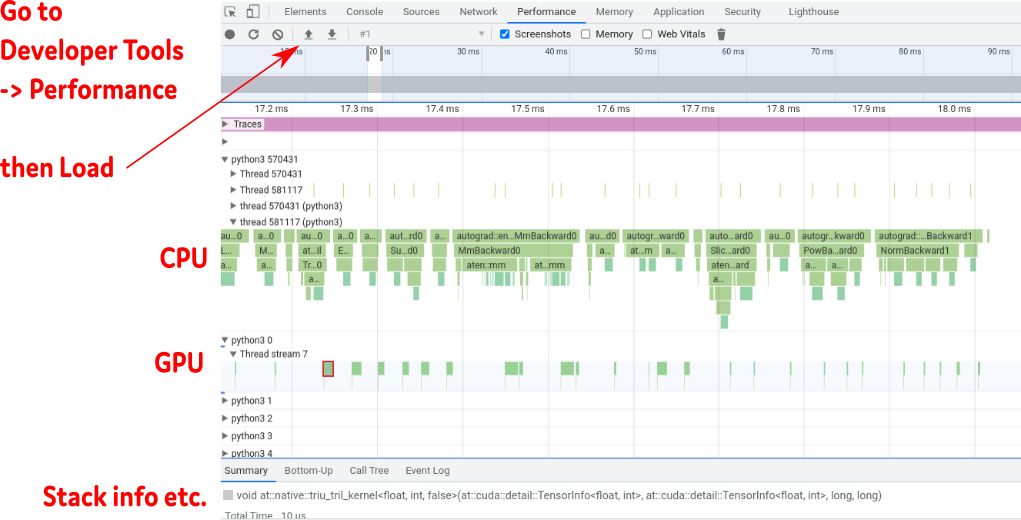

In [103]:
prof.export_chrome_trace('example_trace.json')

# Live speedup of a model

We speed up a model I came across last week.
I have rearranged the training loop but left computation unchanged.

We will be using the [Grapevine leaf dataset](https://www.kaggle.com/maximvlah/grapevine-leaves) (c) 2021 by Maxim Vlah and licensed CC BY-NC-SA 4.0, used with permission here.

I cannot emphasize enough that while we will get considerable speedups, assembling and releasing a useful dataset is an awesome accomplishment and the model as provided is completely "fit for purpose" as a demo of the dataset. Thank you Maxim!

## Summary of our optimization steps

Optimization steps (timings from the rehersal, computer is a Ryzen 5950 w. GTX3090):
- Measure (`time.perf_counter`, `torch.profiler.profile`). 3 epochs in approx. 67 seconds
- Move to SSD. 65 seconds
- num_workers 17.5 seconds
- move augmentation to GPU 13.5 seconds
- pre-scale images 7.6 seconds
- load into memory 5.56 seconds
- take away sync points 1.5-3 seconds

### Hard Optimization

...when your GPU is fully utilized, there might still be optimization potential (similar to the uniformity loss example).

Remember that computation is roughly
  - fixed overhead (kernel launches etc.),
  - reading / writing memory,
  - "real computation".

Now, reading / writing memory typically is much slower than the computation (in registers).
But every PyTorch operation loads tensors from memory, processes them, and writes them back.

If we can do several operations at once, we can save a lot of time on the memory access!

Let's try speeding things up. But if we will define our own kernels, we need to have a way to define the backwards for them, so enter `autograd.Function`s.

## Own Autograd functions

Let's consider $f : \mathbb{R}^n \rightarrow \mathbb{R}^m$ implicitly given by $F(x,f(x))=0$ for some function $F : \mathbb{R}^n \times \mathbb{R}^m \rightarrow \mathbb{R}$.

For nice (smooth, nondegenerate) functions, the [implicit function theorem](https://en.wikipedia.org/wiki/Implicit_function_theorem)
gives us:

Given $x,y$ such that $F(x,y) = 0$ there is a neighborhood $U\ni x$ and a function $f$ such that $f(x)=y$ and $F(x,f(x))=0$. And if $F$ is nice enough, we can also compute the derivative of $f$ at $x$, namely  $\frac{df}{dx}(x) = - (\frac{dF}{dy}(x,y))^{-1} \frac{dF}{dx}(x,y)$.

Given $F$ in PyTorch, can we define $f$ and backpropagate through the computation?

$\Rightarrow$ Need to extend autograd.

In [1]:
import torch
class Implicit(torch.autograd.Function):  # derive autograd.Function
    @staticmethod
    def forward(ctx, x, y0, F, max_iter=100):  # Context ctx as special first parameter to static method forward
        with torch.enable_grad():
            y = y0.clone().detach().requires_grad_()
            xv = x.detach()
            opt = torch.optim.LBFGS([y], max_iter=max_iter)  # numerical search for y s.t. F(x, y) = 0
            def reevaluate():
                opt.zero_grad()
                z = F(xv,y)**2
                z.backward()
                return z
            opt.step(reevaluate)
        ctx._the_function = F                 # save non-tensors
        ctx.save_for_backward(x, y)           # safely save tensors
        return y
    @staticmethod
    def backward(ctx, output_grad):          # ouput_grad = dl / dy
        x, y = ctx.saved_tensors             # get the saved tensors
        F = ctx._the_function                # other arguments
        with torch.enable_grad():
            xv = x.detach().requires_grad_()
            y = y.detach().requires_grad_()
            z = F(xv,y)
            z.backward()
        return -xv.grad/y.grad*output_grad, None, None, None  # return dl / dx and None for all other inputs


Let's try it on a simple case:

In [2]:
def circle(x,y):
    return x**2+y**2-1  # 0-set = unit circle

x = torch.tensor([0.5], dtype=torch.double, requires_grad=True)
y0 = torch.tensor([0.5], dtype=torch.double) # starting value
y= Implicit.apply(x, y0, circle)    # this is how to use our new function
print (y, (1-0.5**2)**0.5)
gr, = torch.autograd.grad(y, x)
gr_exp, = torch.autograd.grad((1-x**2)**0.5, [x])
gr, gr_exp

tensor([0.8660], dtype=torch.float64, grad_fn=<ImplicitBackward>) 0.8660254037844386


(tensor([-0.5774], dtype=torch.float64),
 tensor([-0.5774], dtype=torch.float64))

We could now backpropagate through it, too. And we can focus on the compute for optimization, as we can connect forward and backward now.

# Back to optimization

## Example: Intersection over Union measure


<img src="iou.svg" style="float: right;" />

...for detection models.

Many elementwise operations. Usually PyTorch executes them one by one, reading input from memory and writing back outputs.

By fusing this into a single GPU kernel, we can save all that.


In [4]:
def ratio_iou(x1, y1, w1, h1, x2, y2, w2, h2):
    xi = torch.max(x1, x2)                                # Intersection (yi similarly)
    yi = torch.max(y1, y2)                                # Intersection (yi similarly)
    wi = torch.clamp(torch.min(x1+w1, x2+w2) - xi, min=0)
    hi = torch.clamp(torch.min(y1+h1, y2+h2) - yi, min=0)
    area_i = wi * hi                                      # Area Intersection
    area_u = w1 * h1 + w2 * h2 - area_i                   # Area Union
    return area_i / torch.clamp(area_u, min=1e-5)



# Dropping to C++ as a speedup?

You heard my rule of thumb (if your operands are 100s of elements, Python overhead is not you main problem), but here we go.

In [6]:
import torch.utils.cpp_extension

csrc = """
#include <torch/script.h>

using namespace torch;

Tensor iou_native(const Tensor& x1, const Tensor& y1, const Tensor& w1, const Tensor& h1,
                  const Tensor& x2, const Tensor& y2, const Tensor& w2, const Tensor& h2) {

    auto xi = torch::max(x1, x2);
    auto yi = torch::max(y1, y2);
    auto wi = torch::clamp(torch::min(x1+w1, x2+w2) - xi, 0);
    auto hi = torch::clamp(torch::min(y1+h1, y2+h2) - yi, 0);
    auto area_i = wi * hi;
    auto area_u = w1 * h1 + w2 * h2 - area_i;
    return area_i / torch::clamp(area_u, 1e-5);
}


PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
  m.def("iou_native", &iou_native, "Intersection over union");
}

"""

super_iou = torch.utils.cpp_extension.load_inline("libsuperiou", csrc, is_python_module=True, verbose=True)

Using /home/tv/.cache/torch_extensions/py39_cu113 as PyTorch extensions root...
No modifications detected for re-loaded extension module libsuperiou, skipping build step...
Loading extension module libsuperiou...


# Let's look at the numbers...


In [7]:
x1, y1, w1, h1, x2, y2, w2, h2 = torch.randn(8, 100, 1000, device='cuda').exp()
# check that it works, this is one of the rare places I compare with "=="
assert (ratio_iou(x1, y1, w1, h1, x2, y2, w2, h2)==super_iou.iou_native(x1, y1, w1, h1, x2, y2, w2, h2)).all().item()

def taketime(fn):
    _ = fn(x1, y1, w1, h1, x2, y2, w2, h2)
    torch.cuda.synchronize()

torch.cuda.synchronize()
%timeit taketime(ratio_iou)
%timeit taketime(super_iou.iou_native)


84.5 µs ± 159 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
82 µs ± 100 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [8]:
# but if we do our own CUDA kernels...
csrc = """
#include <torch/extension.h>
#include <ATen/Parallel.h>
#include <ATen/TensorAccessor.h>

using namespace torch;

// The cuda kernel is easy enough
template<typename scalar_t>
__global__ void iou_kernel_gpu(PackedTensorAccessor32<scalar_t, 1> result,
                          PackedTensorAccessor32<scalar_t, 1> x1,
                          PackedTensorAccessor32<scalar_t, 1> y1,
                          PackedTensorAccessor32<scalar_t, 1> w1,
                          PackedTensorAccessor32<scalar_t, 1> h1,
                          PackedTensorAccessor32<scalar_t, 1> x2,
                          PackedTensorAccessor32<scalar_t, 1> y2,
                          PackedTensorAccessor32<scalar_t, 1> w2,
                          PackedTensorAccessor32<scalar_t, 1> h2
                          ) {
    int i = threadIdx.x + blockDim.x * blockIdx.x;
    if (i >= x1.size(0)) // we might have more threads than work to do in the last block
      return;
    // This should look very familiar. We could try reading each element only once, but let's keep it simple.
    scalar_t xi = max(x1[i], x2[i]);
    scalar_t yi = max(y1[i], y2[i]);
    scalar_t wi = max(min(x1[i]+w1[i], x2[i]+w2[i]) - xi, static_cast<scalar_t>(0));
    scalar_t hi = max(min(y1[i]+h1[i], y2[i]+h2[i]) - yi, static_cast<scalar_t>(0));
    scalar_t area_i = wi * hi;
    scalar_t area_u = w1[i] * h1[i] + w2[i] * h2[i] - area_i;
    result[i] = area_i / max(area_u, static_cast<scalar_t>(0.00001f));
}

// The CPU kernel is looks similar, we could also just put it in the main function...
template<typename scalar_t>
void iou_kernel_cpu(int64_t size,
                    scalar_t* result,
                    scalar_t* x1,
                    scalar_t* y1,
                    scalar_t* w1,
                    scalar_t* h1,
                    scalar_t* x2,
                    scalar_t* y2,
                    scalar_t* w2,
                    scalar_t* h2) {

    // we use CPU parallelization
    constexpr int64_t GRAIN_SIZE = 8192; // minimum grain size for parallel execution
    at::parallel_for(0, size, GRAIN_SIZE, [&](int64_t i_begin, int64_t i_end) {
        for (int64_t i = i_begin; i < i_end; ++i) {
            scalar_t xi = max(x1[i], x2[i]);
            scalar_t yi = max(y1[i], y2[i]);
            scalar_t wi = max(min(x1[i]+w1[i], x2[i]+w2[i]) - xi, static_cast<scalar_t>(0));
            scalar_t hi = max(min(y1[i]+h1[i], y2[i]+h2[i]) - yi, static_cast<scalar_t>(0));
            scalar_t area_i = wi * hi;
            scalar_t area_u = w1[i] * h1[i] + w2[i] * h2[i] - area_i;
            result[i] = area_i / max(area_u, static_cast<scalar_t>(0.00001f));
        }
    });
}


torch::Tensor iou_forward(const Tensor& x1, const Tensor& y1, const Tensor& w1, const Tensor& h1,
                          const Tensor& x2, const Tensor& y2, const Tensor& w2, const Tensor& h2) {
  auto res = torch::empty_like(x1);
  for (auto& t : {x1, y1, w1, h1, x2, y2, w2, h2}) {
     AT_ASSERTM(t.dim()==1 && t.size(0)==x1.size(0) && t.device()==x1.device() && t.dtype()==x1.dtype(),
                "tensors are not of same shape and kind");
  }
  if (x1.is_cuda()) {
    dim3 block(512);
    dim3 grid((x1.size(0)+511)/512);
    AT_DISPATCH_FLOATING_TYPES(x1.type(), "iou", [&] {
      iou_kernel_gpu<scalar_t><<<grid,block>>>(res.packed_accessor32<scalar_t, 1>(),
                              x1.packed_accessor32<scalar_t, 1>(),
                              y1.packed_accessor32<scalar_t, 1>(),
                              w1.packed_accessor32<scalar_t, 1>(),
                              h1.packed_accessor32<scalar_t, 1>(),
                              x2.packed_accessor32<scalar_t, 1>(),
                              y2.packed_accessor32<scalar_t, 1>(),
                              w2.packed_accessor32<scalar_t, 1>(),
                              h2.packed_accessor32<scalar_t, 1>());
    });
  } else {
    AT_DISPATCH_FLOATING_TYPES(x1.type(), "iou", [&] {
      iou_kernel_cpu<scalar_t>(x1.size(0),
                              res.data_ptr<scalar_t>(),
                              x1.data_ptr<scalar_t>(),
                              y1.data_ptr<scalar_t>(),
                              w1.data_ptr<scalar_t>(),
                              h1.data_ptr<scalar_t>(),
                              x2.data_ptr<scalar_t>(),
                              y2.data_ptr<scalar_t>(),
                              w2.data_ptr<scalar_t>(),
                              h2.data_ptr<scalar_t>());
    });  
  }
  return res;
}

PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
  m.def("iou_forward", &iou_forward, "Intersection over union");
}
"""

iou_kernel = torch.utils.cpp_extension.load_inline("iou_kernel", "", csrc, is_python_module=True)#, verbose=True)


# Ooofff....

but it works and now the speed is OK!

(By the way: `PackedTensorAccessors` are the closest thing to using tensor indexing in kernels.)


In [9]:
x1, y1, w1, h1, x2, y2, w2, h2 = [t.view(-1) for t in [x1, y1, w1, h1, x2, y2, w2, h2]]

print ("check gpu", (ratio_iou(x1, y1, w1, h1, x2, y2, w2, h2)-iou_kernel.iou_forward(x1, y1, w1, h1, x2, y2, w2, h2)).abs().max())
print ("check cpu", (ratio_iou(x1, y1, w1, h1, x2, y2, w2, h2).cpu()
                     -iou_kernel.iou_forward(x1.cpu(), y1.cpu(), w1.cpu(), h1.cpu(),
                                             x2.cpu(), y2.cpu(), w2.cpu(), h2.cpu())).abs().max())


torch.cuda.synchronize()
%timeit taketime(iou_kernel.iou_forward)
%timeit taketime(ratio_iou)

check gpu tensor(1.7881e-07, device='cuda:0')
check cpu tensor(0.)
15.3 µs ± 138 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
84.7 µs ± 110 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


And now homework! Do the backward... a lot of work, you say?

## Holistic Optimizations - JIT fusers

So currently the fuser is a hotspot of development, look at the competition. We'll use the default `fuser1` here.

In [10]:
help(torch.jit.fuser)

Help on function fuser in module torch.jit._fuser:

fuser(name)
    A context manager that facilitates switching between
    backend fusers.
    
    Valid names:
    * ``fuser0`` - enables only legacy fuser
    * ``fuser1`` - enables only NNC
    * ``fuser2`` - enables only nvFuser



# Intersection over Union with the JIT


Can we have this easier?
Many elementwise operations. Usually PyTorch executes them one by one, reading input from memory and writing back outputs.

We can let PyTorch fuse these into a single GPU kernel, we can save all that.

In [11]:
@torch.jit.script
def ratio_iou_scripted(x1, y1, w1, h1, x2, y2, w2, h2):
    xi = torch.max(x1, x2)                                # Intersection (yi similarly)
    yi = torch.max(y1, y2)                                # Intersection (yi similarly)
    wi = torch.clamp(torch.min(x1+w1, x2+w2) - xi, min=0)
    hi = torch.clamp(torch.min(y1+h1, y2+h2) - yi, min=0)
    area_i = wi * hi                                      # Area Intersection
    area_u = w1 * h1 + w2 * h2 - wi * hi                  # Area Union
    return area_i / torch.clamp(area_u, min=1e-5)


This gives us a good speedup:

In [13]:
x1, y1, w1, h1, x2, y2, w2, h2 = torch.randn(8, 100, 1000, device='cuda').exp()

def take_time(fn):
    _ = fn(x1, y1, w1, h1, x2, y2, w2, h2)
    torch.cuda.synchronize()

take_time(ratio_iou) # warmup
%timeit take_time(ratio_iou)

take_time(ratio_iou_scripted)
take_time(ratio_iou_scripted)
%timeit take_time(ratio_iou_scripted)

85.8 µs ± 123 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
13.6 µs ± 180 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


We can see in the graph specialised for the inputs which operations are fused:

In [9]:
ratio_iou_scripted.graph_for(x1, y1, w1, h1, x2, y2, w2, h2)

graph(%x1.1 : Tensor,
      %y1.1 : Tensor,
      %w1.1 : Tensor,
      %h1.1 : Tensor,
      %x2.1 : Tensor,
      %y2.1 : Tensor,
      %w2.1 : Tensor,
      %h2.1 : Tensor):
  %8 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0), %9 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0), %10 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0), %11 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0), %12 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0), %13 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0), %14 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0), %15 : Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0), %16 : bool = prim::TypeCheck[types=[Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0), Float(100, 1000, strides=[1000, 1], requires_grad=0, device=cuda:0), Float(100, 1000, strides=[1000, 1], requires_grad

# Other optimization options

We can export to optimized or optimization frameworks
  - ONNXRuntime
  - Apache TVM
  - TensorRT/TRTorch

these share some properties:
- work best for inference, but increasingly also for training,
- often use the JIT representation (TorchScript) as format, with ONNXRuntime using ONNX as an additional step,
- there is a push into integrating optimized parts back into PyTorch.
 
Other option: manually implement kernels
 - a lot of work,
 - sometimes the most realistic option when you have very complex algorithms.

# TVM Live-Demo

# Part III: After training our model, are we done?

### Aspects of deployment and the model lifecycle

  - The PyTorch JIT for export
  - Keeping an eye on your model: Drift detection
    - Why, what, how
    - Better drift detection

  

# More PyTorch JIT


So if we have our model in PyTorch. Can we export it?

This is where the PyTorch Just-In-Time compiler comes into play. It provides a graphical representation 
called _TorchScript_  (used somewhat synonymously for the language and the representation).

There are two main ways to get a TorchScript graph:
- scripting and
- tracing.

We'll look at these in some detail.

## Scripting

Scripting compiles (mostly) a subset of Python.
It takes the Python source code and transforms it. 
"Here is what the function should do", just like normal programming.

In [57]:
@torch.jit.script
def fn(x):
    return x * 2

In [58]:
fn, fn.graph

(<torch.jit.ScriptFunction at 0x7f65d43b2220>,
 graph(%x.1 : Tensor):
   %2 : int = prim::Constant[value=2]() # <ipython-input-57-6dcc6c3c1c8e>:3:15
   %3 : Tensor = aten::mul(%x.1, %2) # <ipython-input-57-6dcc6c3c1c8e>:3:11
   return (%3))

### Tracing

Tracing runs the code and observers the calls into PyTorch with some sample input.
"Watch me, now you know how to do the same."

In [59]:
def fn(x):
    return x * 2
fn = torch.jit.trace(fn, [torch.randn(5)])

print(fn.graph, fn.code)

graph(%x : Float(5:1)):
  %1 : Long() = prim::Constant[value={2}]() # <ipython-input-59-7d43d0af2e80>:2:0
  %2 : Float(5:1) = aten::mul(%x, %1) # <ipython-input-59-7d43d0af2e80>:2:0
  return (%2)
 def fn(x: Tensor) -> Tensor:
  return torch.mul(x, CONSTANTS.c0)



N.B.: The specialization for the Tensor shape isn't relevant here and will be erased e.g. during saving of the model.

### TorchScript

One important difference between TorchScript and Python is that in TorchScript everything is typed. Important
types are
- `bool`, `int`, `long`, `double` for numbers (int = 32 bit integer, long = 64 bit integer)
- `Tensor` for tensors (of arbitrary shape, dtype, ...)
- `List[T]` a list with elements fo type T (one of the above)
- Tuples are of fixed size with arbitrary but fixed element type, so e.g. `Tuple(Tensor, int)`.
- `Optional[T]` for things that can be `None`

`None` always is of type `Optional[T]` for some specific `T` (except in the rarest circumstances).

PyTorch will mostly infer the intermediate and return types, but you need to annotate any non-Tensor inputs.

### Tracing vs. Scripting

Scripting will process all code but may not understand all. This means it captures all constructs (like control flow) it understands, but it will fail if it doesn't understand something.

Tracing doesn't see anything not calling into PyTorch and will happily ignore that (e.g. control flow). This is also the reason why it will loudly complain if you have non-tensor inputs.


In [60]:
def fn(x):
    for i in range(x.dim()):
        x = x * x
    return x

script_fn = torch.jit.script(fn)
trace_fn = torch.jit.trace(fn, [torch.randn(5, 5)])

In [61]:
print(script_fn.code)

def fn(x: Tensor) -> Tensor:
  x0 = x
  for i in range(torch.dim(x)):
    x0 = torch.mul(x0, x0)
  return x0



In [62]:
print(trace_fn.code)

def fn(x: Tensor) -> Tensor:
  x0 = torch.mul(x, x)
  return torch.mul(x0, x0)



## Tracing and Scripting Modules

But our models often are not functions. What now?

With tracing, we can work just like with functions. We get a `ScriptModule` subclass that behaves much like a
`Module` with parameters, state dict etc.

In [63]:
traced_model = torch.jit.trace(model, [torch.randn(8, 1)])
type(traced_model), traced_model

(torch.jit._trace.TopLevelTracedModule,
 Sequential(
   original_name=Sequential
   (0): Linear(original_name=Linear)
   (1): Tanh(original_name=Tanh)
   (2): Linear(original_name=Linear)
 ))

Saving is a bit different, here we include the model on purpose:

In [64]:
traced_model.save('./traced_model.pt')
loaded_model = torch.jit.load('./traced_model.pt')

loaded_model(torch.randn(8,1))

tensor([[-0.8112],
        [ 0.3232],
        [ 0.7830],
        [-0.8254],
        [ 0.7857],
        [-0.3138],
        [-0.7612],
        [ 0.5701]], grad_fn=<DifferentiableGraphBackward>)

# Scripting Modules

Scripting modules is ... a bit tricky. We don't script the class in its entirety but instead take an instance (in particular past `__init__`) and process its data members and methods (the latters work like script functions).

In [65]:
scripted_model = torch.jit.script(model)
print(scripted_model.code)

def forward(self,
    input: Tensor) -> Tensor:
  _0 = getattr(self, "0")
  _1 = getattr(self, "1")
  _2 = getattr(self, "2")
  input0 = (_0).forward(input, )
  input1 = (_1).forward(input0, )
  return (_2).forward(input1, )



We can also look at the graph including submodules, but it gets unwieldy rather fast:

In [66]:
scripted_model.forward.inlined_graph

graph(%self : __torch__.torch.nn.modules.container.___torch_mangle_13.Sequential,
      %input.1 : Tensor):
  %2 : __torch__.torch.nn.modules.linear.___torch_mangle_10.Linear = prim::GetAttr[name="0"](%self)
  %3 : __torch__.torch.nn.modules.activation.___torch_mangle_11.Tanh = prim::GetAttr[name="1"](%self)
  %4 : __torch__.torch.nn.modules.linear.___torch_mangle_12.Linear = prim::GetAttr[name="2"](%self)
  %8 : int = prim::Constant[value=1]()
  %9 : int = prim::Constant[value=2]() # /usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1672:22
  %10 : Tensor = prim::GetAttr[name="weight"](%2)
  %11 : Tensor = prim::GetAttr[name="bias"](%2)
  %12 : int = aten::dim(%input.1) # /usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1672:7
  %13 : bool = aten::eq(%12, %9) # /usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1672:7
  %input.3 : Tensor = prim::If(%13) # /usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1672:4
    block0():
      %15 : 

# What can you do with scripted modules?

- Run them as is, bypassing Python.
  - not as much speedup as often is expected (maybe 5%-10% for some models I tested),
  - but - sometimes crucially - it avoids the dreaded Python Global Interpreter Lock (GIL), so it is useful e.g.
    for multithreaded things like serving PyTorch models.
- Export and run in C++ / Mobile / ..., export to other frameworks like [TVM](https://tvm.ai/).


# PyTorch is ... Pythonic, but not Python only


<img src="Ch15_F4_PyTorch_calling_pytorch.svg" style="float: right;"/>

When we looked at _PyTorch is functions_, we actually conflated PyTorch the interface and PyTorch the backend.

The JIT was another way of accessing the backend.

Looking closer, we have `libtorch` (the C++-implemented autograd-enabled backend) calling down into `ATen` for tensor operations and there the dispatching to ATen's own kernels or libraries.



## Beyond Python


<table>
    <tr><td>
We can also run our JITed models from C++ in a few lines of code or on mobile.

The picture shows a CycleGAN running on PyTorch Mobile (from Chapter 15 of our book, just like the PyTorch sketch above).

We also cover C++ there, but not now.
        </td>
        <td><img src="Ch15_F5_PyTorch_zebra_app.png" width="40%"/></td></tr>

<center><img alt="Thank you" src="thank_you.svg" width=80% /></center>

<center><img alt="Your questions and comments" src="your_questions_and_comments.svg" width=80%/></center>

[Graves style Handwriting in PyTorch](https://github.com/t-vi/pytorch-tvmisc/blob/master/misc/graves_handwriting_generation.ipynb)

# Contact: Thomas Viehmann, <https://lernapparat.de/>,  <tv@mathinf.eu>

